In [2]:
pip install pynufft

  Obtaining dependency information for pynufft from https://files.pythonhosted.org/packages/6c/b6/9c6d39a41ed555fbed1668c73c6ab28b474a054efcf8100c642294ed365d/pynufft-2024.1.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB 1.3 MB/s eta 0:00:13
   ---------------------------------------- 0.1/16.2 MB 1.1 MB/s eta 0:00:15
    --------------------------------------- 0.4/16.2 MB 3.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.0/16.2 MB 6.6 MB/s eta 0:00:03
   --- ------------------------------------ 1.5/16.2 MB 7.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.9/16.2 MB 8.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.9/16.2 MB 9.2 MB/s eta 0:00:02
   -------- ------------------------------- 3.5/16.2 MB 10.0 MB/s eta 0:00:02
   --------- ------------------------------ 4.0/16.2 MB 9.8 MB/s eta 0:00:02
   ----------- -------------------

## Nonuniform FFT


    3214.000   0.011     -1.002     -0.026   
0       3218      0.032     -1.018      0.030
1       3219      0.063     -1.020     -0.028
2       3221      0.046     -0.993     -0.054
3       3224      0.016     -1.008     -0.037
4       3224      0.065     -1.002     -0.044


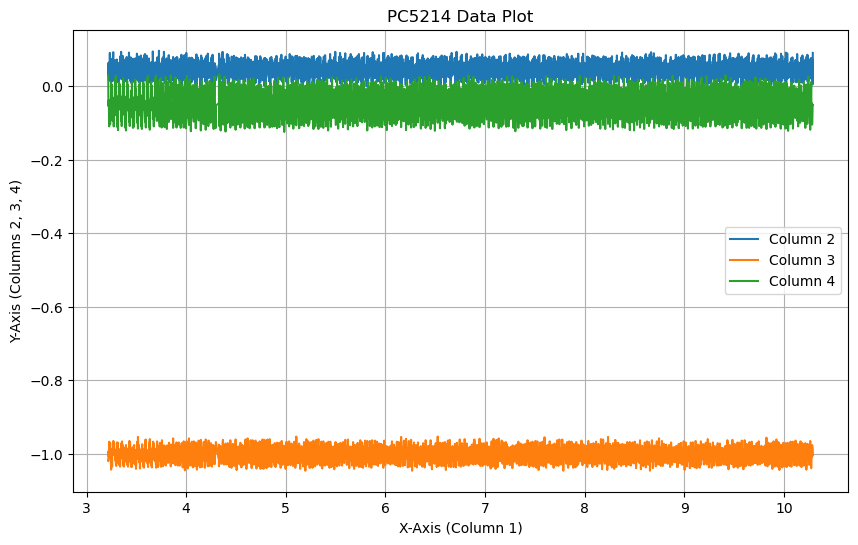

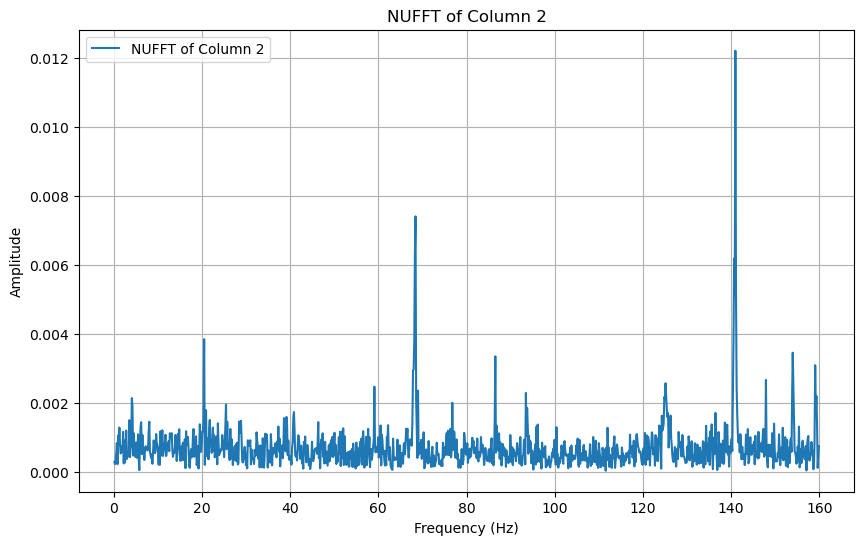

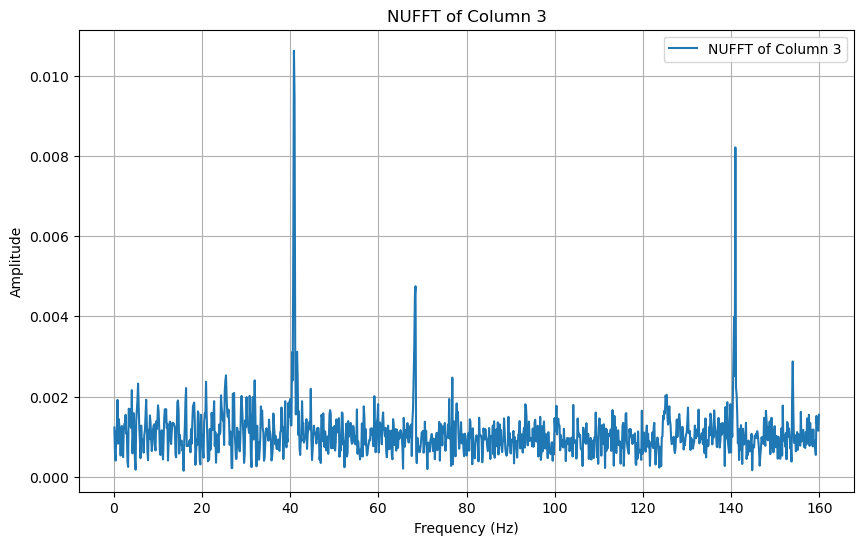

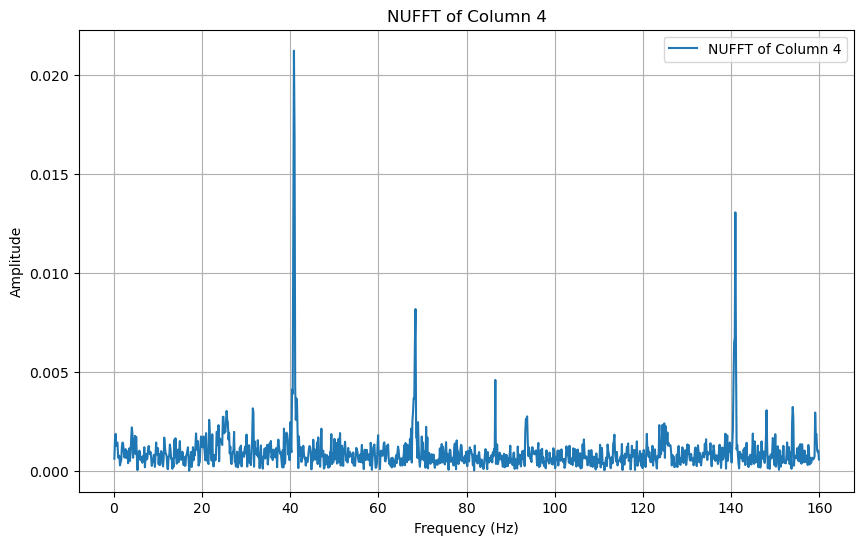

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from pynufft import NUFFT

# 读取 Excel 文件
file_name = '100hz_2.xlsx'
df = pd.read_excel(file_name)

# 确保数据成功读取
print(df.head())

# 绘图
plt.figure(figsize=(10, 6))

# 假设第一列为横坐标，第二列、第三列和第四列为纵坐标
x = df.iloc[:, 0].values*0.001
y1 = df.iloc[:, 1].values
y2 = df.iloc[:, 2].values
y3 = df.iloc[:, 3].values

plt.plot(x, y1, label='Column 2')
plt.plot(x, y2, label='Column 3')
plt.plot(x, y3, label='Column 4')

# 添加标题和标签
plt.title('PC5214 Data Plot')
plt.xlabel('X-Axis (Column 1)')
plt.ylabel('Y-Axis (Columns 2, 3, 4)')
plt.legend()

# 显示图表
plt.grid(True)
plt.show()

# 去除重复的 x 值
unique_x, unique_indices = np.unique(x, return_index=True)
y1 = y1[unique_indices]
y2 = y2[unique_indices]
y3 = y3[unique_indices]

# 对数据进行插值
uniform_x = np.linspace(unique_x.min(), unique_x.max(), len(unique_x))
interp_func_y1 = interp1d(unique_x, y1, kind='cubic')
interp_func_y2 = interp1d(unique_x, y2, kind='cubic')
interp_func_y3 = interp1d(unique_x, y3, kind='cubic')

y1_interp = interp_func_y1(uniform_x)
y2_interp = interp_func_y2(uniform_x)
y3_interp = interp_func_y3(uniform_x)



# 使用 pynufft 进行非均匀傅立叶变换
def plot_nufft(y, x_values, label):
    N = len(y)
    Nd = (N,)  # 输出网格大小
    Kd = (int(N*1.5),)  # 过采样的网格大小
    Jd = (6,)  # 插值核的大小
    nufft_obj = NUFFT()
    
    # 确保 om 是一个二维数组
    om = 2.0 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())
    om = om.reshape((-1, 1))  # 将 om 转换为列向量
    
    nufft_obj.plan(om, Nd, Kd, Jd)
    y_nufft = nufft_obj.forward(y)
    freqs = np.fft.fftfreq(N, d=(x_values[1] - x_values[0]))[:N // 2]

    plt.figure(figsize=(10, 6))
    plt.plot(freqs[1:], 2.0 / N * np.abs(y_nufft[1:N // 2]), label=f'NUFFT of {label}')
    plt.title(f'NUFFT of {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# 绘制每个列的非均匀傅立叶变换
plot_nufft(y1_interp, uniform_x, 'Column 2')
plot_nufft(y2_interp, uniform_x, 'Column 3')
plot_nufft(y3_interp, uniform_x, 'Column 4')

## Uniform FFT


    3214.000   0.011     -1.002     -0.026   
0       3218      0.032     -1.018      0.030
1       3219      0.063     -1.020     -0.028
2       3221      0.046     -0.993     -0.054
3       3224      0.016     -1.008     -0.037
4       3224      0.065     -1.002     -0.044


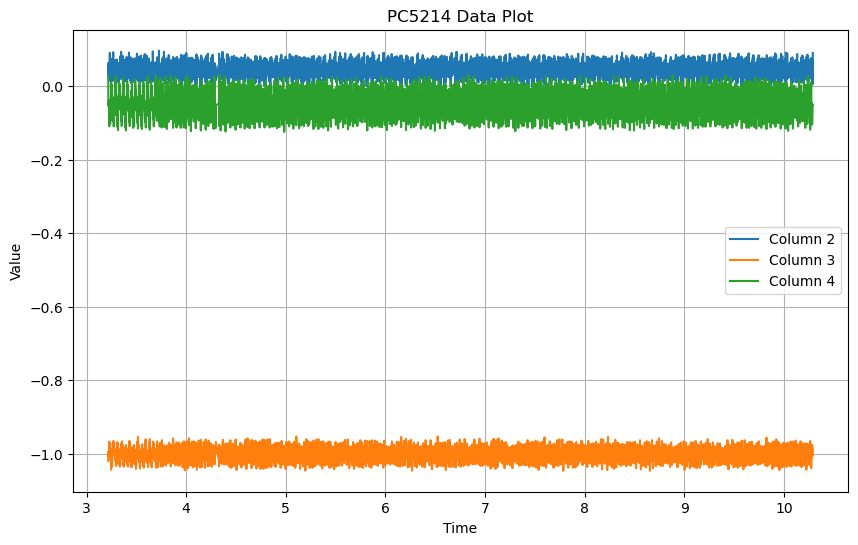

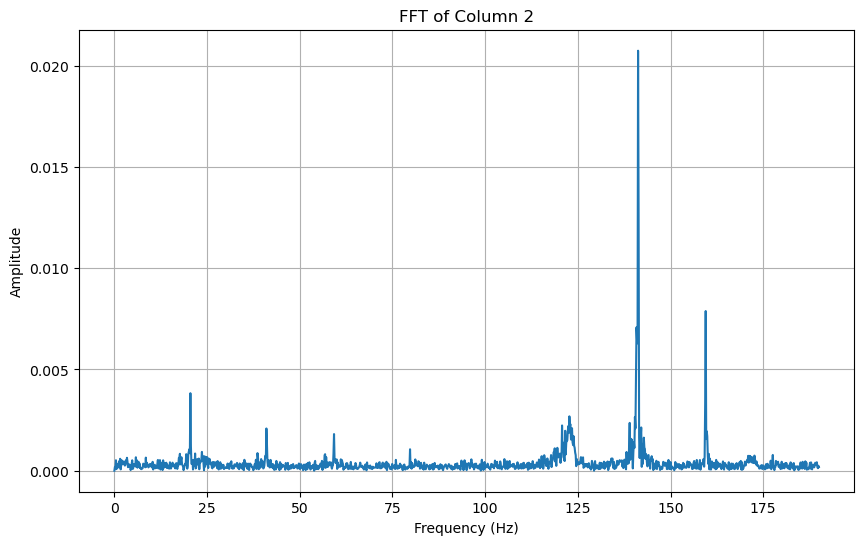

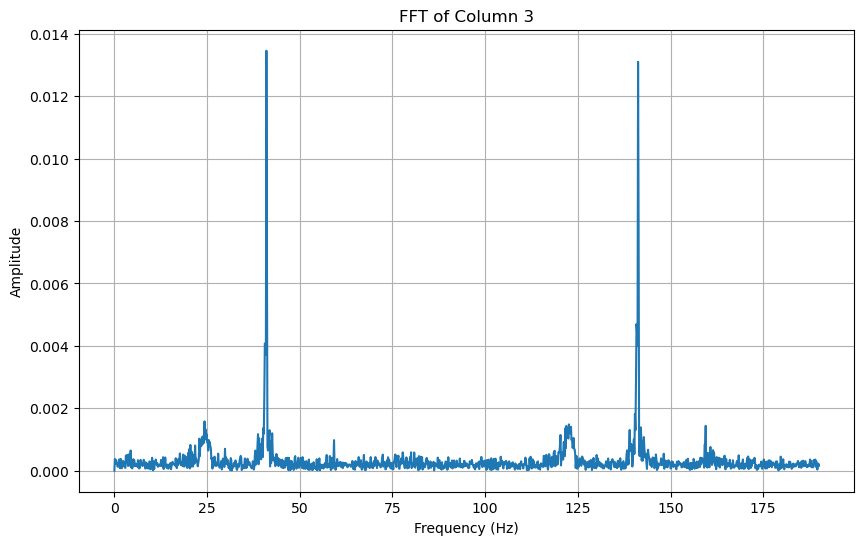

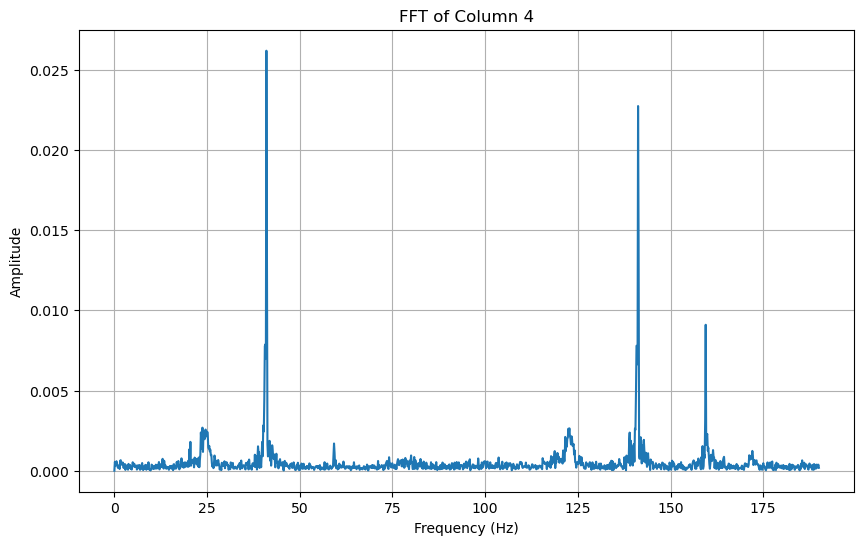

平均采样率: 380.48 Hz


In [20]:

from scipy.signal import detrend

# 读取 Excel 文件
file_name = '100hz_2.xlsx'
df = pd.read_excel(file_name)

# 确保数据成功读取
print(df.head())

# 提取数据
x = df.iloc[:, 0].values *0.001  # 时间
y1 = df.iloc[:, 1].values
y2 = df.iloc[:, 2].values
y3 = df.iloc[:, 3].values

# 计算平均时间间隔
dt = np.mean(np.diff(x))

# 定义FFT函数
def plot_fft(y, dt, label):
    # 去除线性趋势
    y_detrended = detrend(y)
    
    # 执行FFT
    N = len(y)
    yf = np.fft.fft(y_detrended)
    xf = np.fft.fftfreq(N, dt)[:N//2]
    
    # 绘制频谱
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.title(f'FFT of {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# 绘制原始数据
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Column 2')
plt.plot(x, y2, label='Column 3')
plt.plot(x, y3, label='Column 4')
plt.title('PC5214 Data Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 对每列数据进行FFT
plot_fft(y1, dt, 'Column 2')
plot_fft(y2, dt, 'Column 3')
plot_fft(y3, dt, 'Column 4')

# 打印平均采样率
print(f"平均采样率: {1/dt:.2f} Hz")